# [NTDS'18] milestone 2: network models
[ntds'18]: https://github.com/mdeff/ntds_2018

[Hermina Petric Maretic](https://people.epfl.ch/hermina.petricmaretic), [EPFL LTS4](https://lts4.epfl.ch)

## Students

* Team: `10`
* Students: `<the name of all students in the team>`
* Dataset: `<the dataset you used to complete the milestone>`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* In the first part, you cannot import any other library than we imported. In the second part, you are allowed to import any library you want.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The purpose of this milestone is to explore various random network models, analyse their properties and compare them to your network. In the first part of the milestone you will implement two random graph models and try to fit them to your network. In this part you are not allowed to use any additional package. In the second part of the milestone you will choose a third random graph model that you think shares some properties with your network. You will be allowed to use additional packages to construct this network, but you must explain your network choice. Finally, make your code as clean as possible, and keep your textual answers short.

## Part 0

Import the adjacency matrix of your graph that you constructed in milestone 1, as well as the number of nodes and edges of your network.

In [306]:
adjacency =  np.load("../saved_adjacency.npy")
n_nodes =  len(adjacency)
n_edges =  int(sum(sum(adjacency > 0))/2)

## Part 1

**For the computation of this part of the milestone you are only allowed to use the packages that have been imported in the cell below.**

In [307]:
%matplotlib inline

import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

import networkx as nx
import pygsp

### Question 1

Create a function that constructs an Erdős–Rényi graph.

In [308]:
def erdos_renyi(n, p, seed=None):
    """Create an instance from the Erdos-Renyi graph model.
    
    Parameters
    ----------
    n: int
        Size of the graph.
    p: float
        Edge probability. A number between 0 and 1.
    seed: int (optional)
        Seed for the random number generator. To get reproducible results.
    
    Returns
    -------
    adjacency
        The adjacency matrix of a graph.
    """
    # Initializing "adjacency" as an empty n x n matrix
    adjacency = np.zeros((n,n))
    # Initializing the random number generation with the desired seed
    random.seed(seed)
    
    for i in range(n):
        for j in range(i+1, n, 1):
            # If the generated number (between 0 and 1) is smaller than the probability, an edge is created
            if (random.random() < p):
                adjacency[i,j]=adjacency[j,i]=1
    
    return adjacency

Text(0.5, 1.05, 'Erdos-Renyi (5, 0.6)')

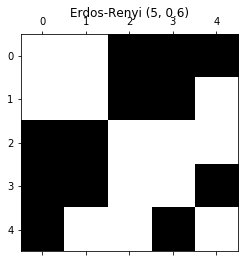

In [309]:
er = erdos_renyi(5, 0.6, 9765)
plt.spy(er)
plt.title('Erdos-Renyi (5, 0.6)')

Text(0.5, 1.05, 'Erdos-Renyi (10, 0.4)')

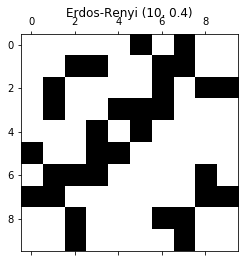

In [310]:
er = erdos_renyi(10, 0.4, 7648)
plt.spy(er)
plt.title('Erdos-Renyi (10, 0.4)')

### Question 2

Use the function to create a random Erdos-Renyi graph. Choose the parameters such that number of nodes is the same as in your graph, and the number of edges similar. You don't need to set the random seed. Comment on your choice of parameters.

In [311]:
# Binarization of adjacency matrix, in this milestone, the weights aren't relevant
adjacency=np.where(adjacency != 0, 1, 0)

# L max is equal to the number of distinct pair of nodes present in the graph
L_max=int(n_nodes*(n_nodes-1)/2)
print('L_max = ',L_max)

print('Our Network:')
# Number of edges in our network was computed before as n_edges
print('L_net =',n_edges)

# Computing the density of our network which represents the probability in the Erdos-Renyi model
L_Prob = n_edges/L_max

print('Our Link probability = ',L_Prob)

# Creating a graph of the same size as ours, that will have approximately the same number of links
er=erdos_renyi(n_nodes, L_Prob, seed=15)
print('Random Network:')

L_er=int(np.sum(er)/2)
print('L_er =',L_er)

# Densitiy of the Erdos-Renyi graph
print('ER Link probability = ',L_er/L_max)

L_max =  4921953
Our Network:
L_net = 163621
Our Link probability =  0.03324310492196898
Random Network:
L_er = 163664
ER Link probability =  0.03325184129145484


Knowing from milestone 1 that the maximum number of links L_max = 4921953 and the total number of links L = 163621, we can assume that the link probability of our graph is L/L_max = 0.0332431 –> 3.32%

### Question 3

Create a function that constructs a Barabási-Albert graph.

In [312]:
def barabasi_albert(n, m, m0=2, seed=None):
    """Create an instance from the Barabasi-Albert graph model.
    
    Parameters
    ----------
    n: int
        Size of the graph.
    m: int
        Number of edges to attach from a new node to existing nodes.
    m0: int (optional)
        Number of nodes for the inital connected network.
    seed: int (optional)
        Seed for the random number generator. To get reproducible results.
    
    Returns
    -------
    adjacency
        The adjacency matrix of a graph.
    """
    
    if m0<m:
        print("m0 has been changed from",m0,"to",m)
        m0=m
    
    # Initializing random seed
    random.seed(seed)
    # Empty adjacency matrix to fill
    adjacency = np.zeros((n,n))
 
    # List of already connected nodes: Nodes with X connections will appear X times (Preferential attachment)
    connected = []

    # Set of nodes to_connect to (use of set to avoid multiple links between two nodes)
    # Loop to connect the initial network as a randomly connected path graph
    initial = list(range(m0))
    random.shuffle(initial)
    for i in range(len(initial)-1):
        adjacency[initial[i], initial[i+1]] = 1
        adjacency[initial[i+1], initial[i]] = 1
        connected.extend([initial[i], initial[i+1]])
        
    # Set of nodes to_connect to (use of set to avoid multiple links between two nodes)
    to_connect = set()
    
    # Particular case where m0=1 and therefore "connected" is empty
    if m0==1:
        to_connect.add(0)
    
    # Random selection of nodes "to_connect" to
    while len(to_connect) < m:
        to_connect.add(random.choice(connected))

    # Index of the first node to add to the network
    selected = m
    
    while selected < n :
        # Creation of links between the "selected" node and the "to_connect" one(s)
        for node in to_connect:
            adjacency[selected, node]=1
            adjacency[node, selected]=1
        
        # Indexes of nodes connected on the above operation are added to the "connected" list
        connected.extend(list(to_connect))
        # Selected node is added m times on the list since m new links are created
        connected.extend([selected for i in range(m)])
        
        # Reset of set
        to_connect=set()
        
        # Searching for m different randomly chosen node "to_connect" to
        while len(to_connect) < m:
            to_connect.add(random.choice(connected))
        
        selected+=1
    
    return adjacency

Text(0.5, 1.05, 'Barabasi-Albert (5, 1)')

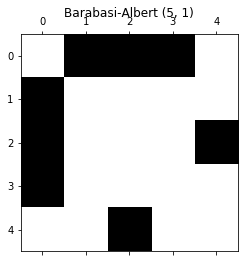

In [313]:
ba = barabasi_albert(5, 1, 2, 9087)
plt.spy(ba)
plt.title('Barabasi-Albert (5, 1)')

Text(0.5, 1.05, 'Barabasi-Albert (10, 2)')

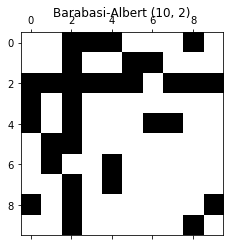

In [314]:
ba = barabasi_albert(10, 2, 3, 8708)
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.spy(ba)
plt.title('Barabasi-Albert (10, 2)')

### Question 4

Use the function to create a random Barabási-Albert graph. Choose the parameters such that number of nodes is the same as in your graph, and the number of edges similar. You don't need to set the random seed. Comment on your choice of parameters.

In [315]:
print('L_max = ',L_max)

print('Our Network:')
print('L_net =',n_edges)

# Solutions of 2nd degree equation described below
m_1 = 0.5*((n_nodes+1)+(((n_nodes+1)**2-4*(n_edges+1))**(0.5)))
m_2 = 0.5*((n_nodes+1)-(((n_nodes+1)**2-4*(n_edges+1))**(0.5)))
print("m 1:", m_1, "m 2:", m_2)

print("B/A Model with m=53:")
ba = barabasi_albert(n=n_nodes, m=53, m0=53)

L_ba = sum(sum(ba))/2
print('L_ba =',L_ba)

L_max =  4921953
Our Network:
L_net = 163621
m 1: 3085.978898633278 m 2: 53.02110136672195
B/A Model with m=53:
L_ba = 163557.0


Considering m0=m, after the first iteration, the Barabasi/Albert model network has m+1 nodes and m+(m-1) links. After the second one, the network has now m+2 nodes and 2m+(m-1) links. We can assume the final network with n = m+(n-m) nodes has L = m*(n-m)+(m-1) links. This last formula gives us a relation between Barbasi/Albert initial parameter m and our network's informations and by solving the following equation, we can determine the optimal parameter:

m^2 - m(n+1) + L + 1 = 0

Since our network has L = 163621 links and n = 3138 nodes it means the best parameters to fit our network are m_1 = 53 or m_2 = 3085 (163'557 links) to have the same number of links and nodes.

### Question 5

Compare the number of edges in all three networks (your real network, the Erdős–Rényi network, and the Barabási-Albert netowk).

In [316]:
print("Our Network has:", L_net,"edges")
print("Erdos Renyi has:", L_er,"edges")
print("Barabsi Albert has:", L_ba,"edges")

Our Network has: 163621.0 edges
Erdos Renyi has: 163664 edges
Barabsi Albert has: 163557.0 edges


Erdos-Renyi network has an average number of links equal to the number of links in our network. Nevertheless, since connections are random, the best way to find the best fitting ER graph is to tune the "seed" parameter. A good fit of our network is obtain with seed = 15.

Barabasi-Albert network has fixed number of links depending on parameters n_nodes, m and m0. Previous evaluation of best parameter (m=53) to fit our network shows that the best fitting BA graph has 163'557 edges. Comparing with other values of parameter m gives: m=52 –> 160'523 edges, m=54 –> 166'589 edges.

### Question 6

Implement a function that computes the [Kullback–Leibler (KL) divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between two probability distributions.
We'll use it to compare the degree distributions of networks.

0.9999999999999957

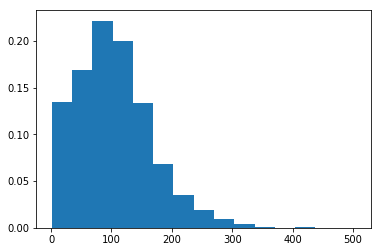

In [317]:
# We create an array containing the degree of each node
degree = np.sum(adjacency,0)
weights = np.ones_like(degree) / float(n_nodes)
deg=plt.hist(degree,weights=weights,  bins=15);

deg_pdf=np.histogram(degree,bins=30,weights=weights)
sum(deg_pdf[0])

In [318]:
def kl_divergence(p, q):
    """Compute the KL divergence between probability distributions of degrees of two networks.
    
    Parameters
    ----------
    p: np.array
        Probability distribution of degrees of the 1st graph.
    q: np.array
        Probability distribution of degrees of the 2nd graph.
    
    Returns
    -------
    kl
        The KL divergence between the two distributions.
    """
    
    kl=0.;
    
    # Using lecture forumla
    for i in range(len(p)):
        if(p[i] and q[i]):
            kl+=p[i]*np.log(p[i]/q[i])
    
    return kl

### Question 7: 

Compare the degree distribution of your network to each of the two synthetic ones, in terms of KL divergence.

**Hint:** Make sure you normalise your degree distributions to make them valid probability distributions.

**Hint:** Make sure none of the graphs have disconnected nodes, as KL divergence will not be defined in that case. If that happens with one of the randomly generated networks, you can regenerate it and keep the seed that gives you no disconnected nodes.

In [319]:
# Definition of bins width and number
wid_bins=35
bins=list(range(0,700,wid_bins))

# Computation of random graph
er = erdos_renyi(n_nodes, 0.0332431, 15)
ba = barabasi_albert(n_nodes, 53, 53)

# Computation of degree vector
deg_er=np.sum(er,0)
deg_ba=np.sum(ba,0)

# Computation of probability density function
deg_pdf=np.histogram(degree,bins=bins,weights=weights)
deg_pdf_er=np.histogram(deg_er,bins=bins,weights=weights)
deg_pdf_ba=np.histogram(deg_ba,bins=bins,weights=weights)

# Set zeroes values to 1e-10 to avoid biaised results of KL divergence (no division by 0)
# Since the added value (1e-10) is very small, these modifications won't influence the normalization condition (sum=1)
deg_pdf[0][deg_pdf[0]<1e-10]=1e-10
deg_pdf_er[0][deg_pdf_er[0]<1e-10]=1e-10
deg_pdf_ba[0][deg_pdf_ba[0]<1e-10]=1e-10

# Computation of KL Divergence comparing both random graph model with our network
print("KL Divergence Erdos Renyi:", kl_divergence(deg_pdf[0],deg_pdf_er[0]))
print("KL Divergence Barabasi Albert:", kl_divergence(deg_pdf[0],deg_pdf_ba[0]))

KL Divergence Erdos Renyi: 8.58530629710921
KL Divergence Barabasi Albert: 2.919801394409692


KL divergence comparison shows that our network PDF is closer to the Barabasi Albert model than to Erdos Renyi model (KL_div is almost 3 times smaller). To improve precision of comparison, one can fit each histogram with a smooth curve and compute KL divergence between those curves.

### Question 8

Plot the degree distribution historgrams for all three networks. Are they consistent with the KL divergence results? Explain.

<BarContainer object of 19 artists>

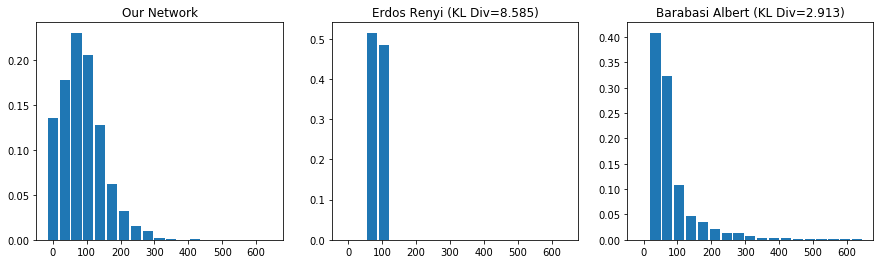

In [320]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.title('Our Network')
plt.bar(bins[:len(bins)-1], deg_pdf[0], width=30)
plt.subplot(132)
plt.title('Erdos Renyi (KL Div=8.585)')
plt.bar(bins[:len(bins)-1], deg_pdf_er[0], width=30)
plt.subplot(133)
plt.title('Barabasi Albert (KL Div=2.913)')
plt.bar(bins[:len(bins)-1], deg_pdf_ba[0], width=30)

First, let's compare our degree distribution with the Erdos Renyi model. Since ER model has a very narrow and located degree distribution (only 2 bars), it's clear that KL divergence will give a quite high value due to the large amount of 0 (forced to 1e-10 in our case) in the histogram.

Looking at both histogram and KL divergence, we can assume that our network is close to the Barabasi Albert model even though its degree distribution is much narrower than ours. Furthermore BA model network has very few (zero if m0=m) nodes with degree < m.

### Question 9

Imagine you got equal degree distributions. Would that guarantee you got the same graph? Explain.

**Your answer here.**

No it wouldn't guarantee the same graph. As seen in lecture 3 (Scale-free networks), slide 25 : we can randomize any network while preserving the degree of each node. This would result in a graph with equal degree distribution to the original but with the links connecting different nodes. Thus, equal degree distributions don't lead to same graphs.

## Part 2

**You are allowed to use any additional library here (e.g., NetworkX, PyGSP, etc.).** Be careful not to include something here and use it in part 1!

### Question 10

Choose a random network model that fits you network well. Explain your choice. 

**Hint:** Check lecture notes for different network models and their properties. Your choice should be made based on at least one property you'd expect to be similar.

**Your answer here.**

### Question 11

Explain (in short) how the chosen model works.

**Your answer here.**

### Question 12

Create a random graph from that model, such that the number of nodes is the same as in your graph.

In [25]:
# Your code here.

G_ours= nx.from_numpy_matrix(np.asmatrix(adjacency))
L_ours=nx.algorithms.shortest_paths.generic.average_shortest_path_length(G_ours)
C_ours=nx.algorithms.cluster.average_c<tlustering(G_ours)

In [27]:
G_erdos = nx.erdos_renyi_graph(n_nodes,0.033)
L_erdos = nx.algorithms.shortest_paths.generic.average_shortest_path_length(G_erdos)
C_erdos = nx.algorithms.cluster.average_clustering(G_erdos)

In [30]:
sigma=(C_ours/C_erdos)/(L_ours/L_erdos)
print(sigma)

5.936682809741164


### Question 13

Check the properties you expected to be similar, and compare to your network.

In [ ]:
# Your code here.

Are the results what you expected? Explain.

**Your answer here.**